In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import random
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import ttest_1samp
import statsmodels.api as sm

Set seeds

In [93]:
seed_value = 52
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Prepare Data 


Additionally, visualize the data

In [94]:
#Load in data
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

df = pd.read_csv(data_path)

ts = df["Close"].values

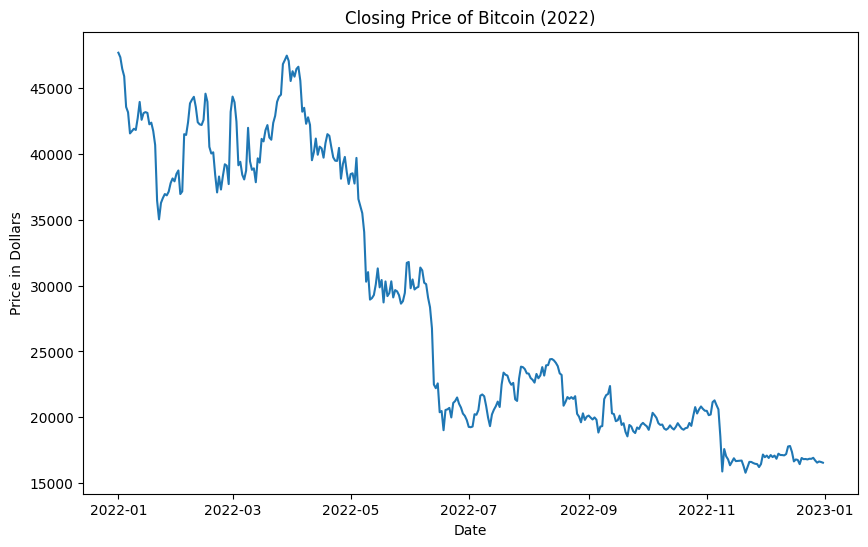

In [95]:
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

plt.figure(figsize=(10, 6))
plt.plot(date_range, ts)
plt.title('Closing Price of Bitcoin (2022)')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')
plt.show()

## Preprocessing Data

Check data type

In [96]:
print(ts.dtype)

float64


In [97]:
ts = ts.astype('float32')
print(ts.dtype)

float32


Check dimensions

In [98]:
print(ts.shape)
ts = ts.reshape(-1,1)
print(ts.shape)

(365,)
(365, 1)


Data conversion

In [99]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ts)

In [100]:
# train-test split for time series
train_size = int(len(scaled_data) * 0.60)
train, rest = scaled_data[:train_size], scaled_data[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

219
73
73


### Create tensor dataset

In [101]:
def create_dataset(dataset, lookback):
    """
    Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X = []
    y = []
    for i in range(len(dataset)-lookback):
        inputs = dataset[i:i+lookback]
        labels = dataset[i+lookback:i+lookback+1]
        X.append(inputs)
        y.append(labels)

    X = np.array(X)
    y = np.array(y)
    return X, y

lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_valid, y_valid = create_dataset(validation, lookback=lookback)

Convert to tensors

In [102]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

X_valid_tensor = torch.tensor(X_valid)
y_valid_tensor = torch.tensor(y_valid)

Inspect shape of tensors

In [103]:
print(f"X_train, y_train shape {X_train.shape, y_train.shape}")
print(f"X_valid, y_valid shape: {X_valid.shape, y_valid.shape}")
print(f"X_test, y_test shape: {X_test.shape, y_test.shape}")

X_train, y_train shape ((218, 1, 1), (218, 1, 1))
X_valid, y_valid shape: ((72, 1, 1), (72, 1, 1))
X_test, y_test shape: ((72, 1, 1), (72, 1, 1))


## LSTM Class


In [104]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=150, num_layers=1, batch_first=True)
        self.linear = nn.Linear(150, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1:, :])
        return x

## Training


In [65]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=32)

#Training configuration
n_epochs = 1000
patience = 25
best_epoch = 0
best_valid_rmse = float('inf')
best_train_rmse = 0
patience_counter = 0

# Loss tracking
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    #Progress Printer
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train_tensor)
            train_rmse = torch.sqrt(loss_fn(y_pred, y_train_tensor))
            
            y_pred = model(X_valid_tensor)
            valid_rmse = torch.sqrt(loss_fn(y_pred, y_valid_tensor))

            train_losses.append(train_rmse.item())
            valid_losses.append(valid_rmse.item())
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, validation RMSE {valid_rmse:.4f}")

    if train_rmse < 0.02:
        #Early stopping
        if valid_rmse < best_valid_rmse:
            best_epoch = epoch
            best_train_rmse = train_rmse
            best_valid_rmse = valid_rmse
            patience_counter = 0
        else:
            patience_counter += 1

        # Stop training if patience has been exceeded
        if patience_counter >= patience:
            print(f"Early stopping at Epoch {epoch}: The train RMSE {train_rmse:.4f}, best validation RMSE {best_valid_rmse:.4f}")
            break

    # if train_rmse < 0.018:
    #       print(f"Stopped at Epoch {epoch} to reduce overfitting: The train RMSE {train_rmse:.4f}, best validation RMSE {best_valid_rmse:.4f}")
    #       break

Epoch 0: train RMSE 0.9842, validation RMSE 0.8472
Epoch 100: train RMSE 0.1190, validation RMSE 0.0577
Epoch 200: train RMSE 0.1187, validation RMSE 0.0573
Epoch 300: train RMSE 0.1190, validation RMSE 0.0579
Epoch 400: train RMSE 0.1187, validation RMSE 0.0569
Epoch 500: train RMSE 0.1194, validation RMSE 0.0571
Epoch 600: train RMSE 0.1190, validation RMSE 0.0580
Epoch 700: train RMSE 0.1187, validation RMSE 0.0562
Epoch 800: train RMSE 0.1187, validation RMSE 0.0581
Epoch 900: train RMSE 0.1190, validation RMSE 0.0567


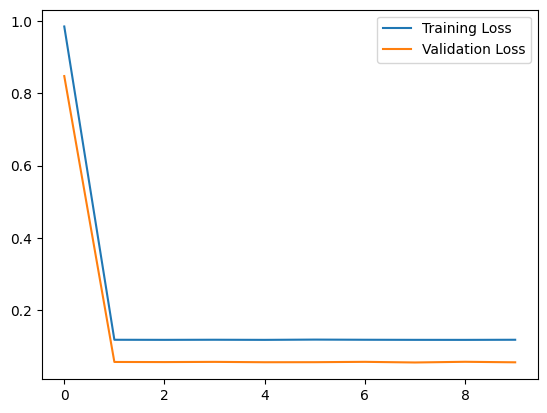

In [66]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.legend()
plt.show()

## Plotting Results of LSTM



train RMSE 1207.6931, validation RMSE 591.7604, test RMSE 629.4030


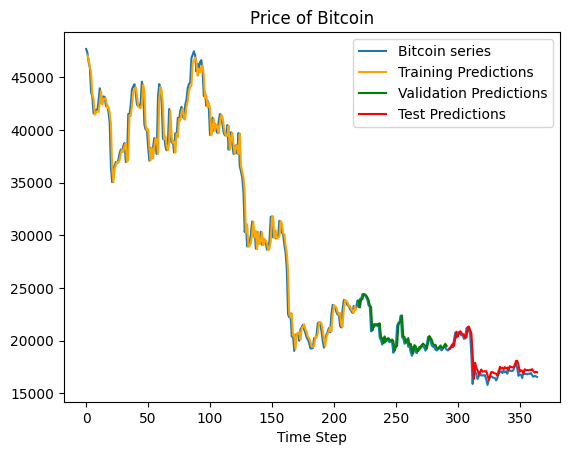

In [88]:
with torch.no_grad():
    #Make predictions
    train_pred = model(X_train_tensor)
    valid_pred = model(X_valid_tensor)
    test_pred = model(X_test_tensor)

# Convert prediction tensor objects to np arrays
train_pred = train_pred.detach().numpy()
valid_pred = valid_pred.detach().numpy()
test_pred = test_pred.detach().numpy()

# Reshape np arrays
train_pred = train_pred.reshape(-1,1)
valid_pred = valid_pred.reshape(-1,1)
test_pred = test_pred.reshape(-1,1)

y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Convert data and predictions to original scale
original_train_pred = scaler.inverse_transform(train_pred)
original_valid_pred = scaler.inverse_transform(valid_pred)
original_test_pred = scaler.inverse_transform(test_pred)

original_y_train = scaler.inverse_transform(y_train)
original_y_valid = scaler.inverse_transform(y_valid)
original_y_test = scaler.inverse_transform(y_test)

#Reshape
original_train_pred = original_train_pred.reshape(-1,1)
original_valid_pred = original_valid_pred.reshape(-1,1)
original_test_pred = original_test_pred.reshape(-1,1)

# Calculate Loss
rmse_train = np.sqrt(mean_squared_error(original_train_pred, original_y_train))
rmse_valid = np.sqrt(mean_squared_error(original_valid_pred, original_y_valid))
rmse_test = np.sqrt(mean_squared_error(original_test_pred, original_y_test))
print(f"train RMSE {rmse_train:.4f}, validation RMSE {rmse_valid:.4f}, test RMSE {rmse_test:.4f}")

# Initialize plots with NaN values
train_plot = np.full_like(ts, np.nan)
valid_plot = np.full_like(ts, np.nan)
test_plot = np.full_like(ts, np.nan)

# Place predictions in their respective plots 
train_plot[lookback:train_size] = original_train_pred
valid_plot[train_size+lookback:train_size+len(y_valid)+lookback] = original_valid_pred
test_plot[train_size+lookback+len(y_valid)+lookback:] = original_test_pred

# plot
plt.plot(ts, label='Bitcoin series')
plt.plot(train_plot, c='orange', label="Training Predictions")
plt.plot(valid_plot, c='green', label='Validation Predictions')
plt.plot(test_plot, c='r', label='Test Predictions')
plt.xlabel('Time Step')
plt.title('Price of Bitcoin')
plt.legend()
plt.show()

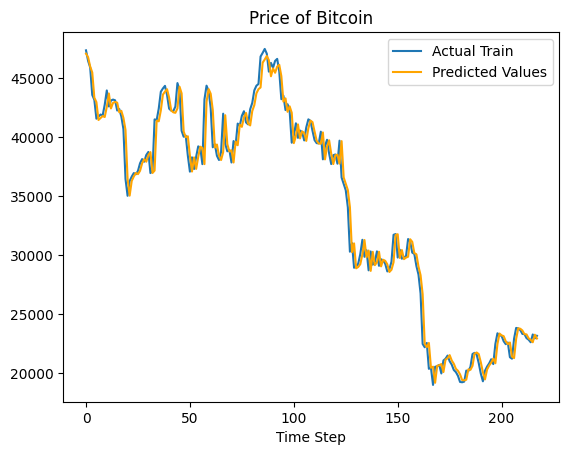

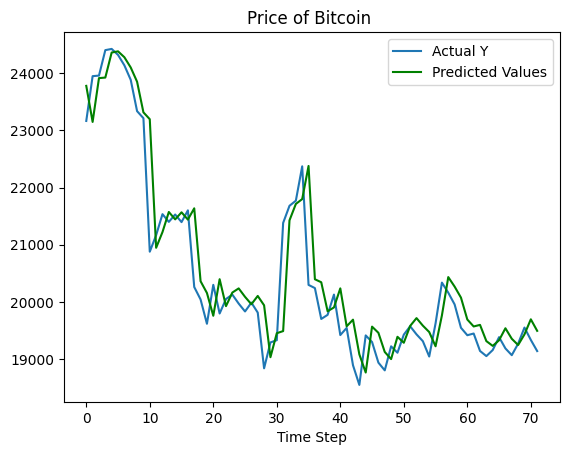

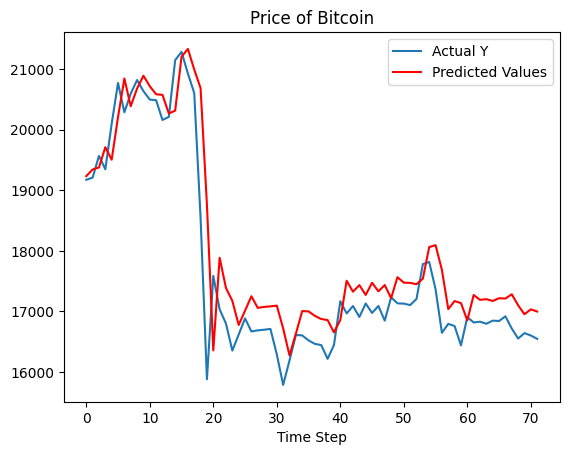

In [89]:
plt.plot(original_y_train, label="Actual Train")
plt.plot(original_train_pred, c='orange', label="Predicted Values")
plt.xlabel('Time Step')
plt.title('Price of Bitcoin')
plt.legend()
# plt.savefig("lstm-train-results.png")
plt.show()

plt.plot(original_y_valid, label="Actual Y")
plt.plot(original_valid_pred, c='green', label="Predicted Values")
plt.xlabel('Time Step')
plt.title('Price of Bitcoin ')
plt.legend()
# plt.savefig("lstm-valid-results.png")
plt.show()

plt.plot(original_y_test, label="Actual Y")
plt.plot(original_test_pred, c='red', label="Predicted Values")
plt.xlabel('Time Step')
plt.title('Price of Bitcoin')
plt.legend()
# plt.savefig("lstm-test-results.png")
plt.show()